# ACP (PCA) — Banques coopératives européennes (2005–2015)

## Objectif
Réduire la dimension des variables financières (bilan/ratios) pour :
- visualiser la structure des banques dans un espace 2D (PC1/PC2),
- identifier les variables qui “drivent” les différences (loadings),
- comparer la période **pré-crise (2005–2010)** vs **post-crise (2011–2015)**.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set_theme(style="whitegrid")


In [2]:
df = pd.read_csv("Theme4_coop_zoom_data.xlsx - coop_zoom_data.csv")

# supprime la colonne parasite si elle existe
df = df.drop(columns=["Unnamed: 10"], errors="ignore")

# conversion des colonnes numériques (virgule -> point)
num_cols = ['ass_total','ass_trade','inc_trade','in_roa','rt_rwa','in_roe','in_trade']
for c in num_cols:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(',', '.'), errors='coerce')

df['periode'] = np.where(df['year'] <= 2010, 'Pré-crise', 'Post-crise')

df.head()


,institution_name,year,country_code,ass_total,ass_trade,inc_trade,in_roa,rt_rwa,in_roe,in_trade,periode
0,Westdeutsche Genossenschafts-Zentralbank AG,2005,DE,73583.66,25365.65,51.712,0.002308,NaN,0.086413,0.104024,Pré-crise
1,Westdeutsche Genossenschafts-Zentralbank AG,2006,DE,81197.70,29676.60,34.000,0.003607,0.285033,0.104101,0.060220,Pré-crise
2,Westdeutsche Genossenschafts-Zentralbank AG,2007,DE,88645.40,35609.40,-50.600,0.002839,0.305430,0.087746,-0.096271,Pré-crise
3,Westdeutsche Genossenschafts-Zentralbank AG,2008,DE,92652.20,37917.30,-571.100,-0.003574,0.238931,-0.129447,-10.836810,Pré-crise
4,Westdeutsche Genossenschafts-Zentralbank AG,2009,DE,95643.30,39020.10,338.900,0.003772,0.196956,0.118423,0.421465,Pré-crise


In [3]:
print("Lignes:", len(df))
print("Banques uniques:", df["institution_name"].nunique())
print("Pays uniques:", df["country_code"].nunique())

df[num_cols].isna().mean().sort_values(ascending=False)


Lignes: 9550
Banques uniques: 1696
Pays uniques: 22


rt_rwa       0.116649
in_trade     0.023037
inc_trade    0.020733
ass_trade    0.011937
in_roe       0.004921
in_roa       0.004293
ass_total    0.000000
dtype: float64

## Variables utilisées pour l’ACP
On retient des variables quantitatives (bilan/ratios).  
On standardise (z-score) car les échelles sont très différentes (assets vs ratios).


In [4]:
vars_pca = ['ass_total','ass_trade','inc_trade','in_roa','rt_rwa','in_roe','in_trade']
vars_pca = [v for v in vars_pca if v in df.columns]

X = df[vars_pca].copy()

# imputation médiane
for v in vars_pca:
    X[v] = X[v].fillna(X[v].median())

X.shape


(9550, 7)

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
pca_full = PCA()
pca_full.fit(X_scaled)

explained = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained)

explained[:5], cum_explained[:5]


(array([0.35686397, 0.20830654, 0.14709211, 0.13748175, 0.07732761]),
 array([0.35686397, 0.56517051, 0.71226262, 0.84974437, 0.92707199]))

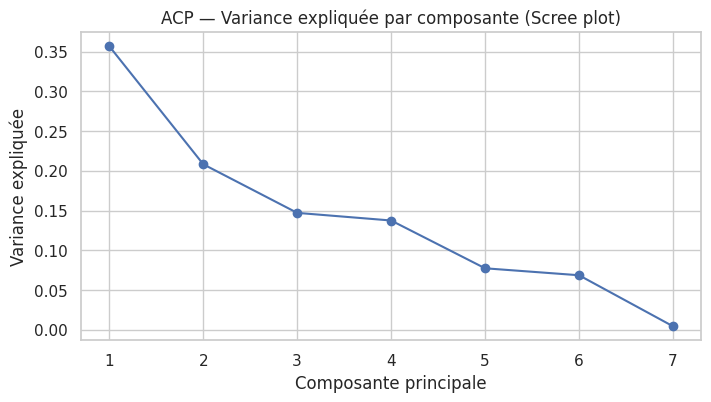

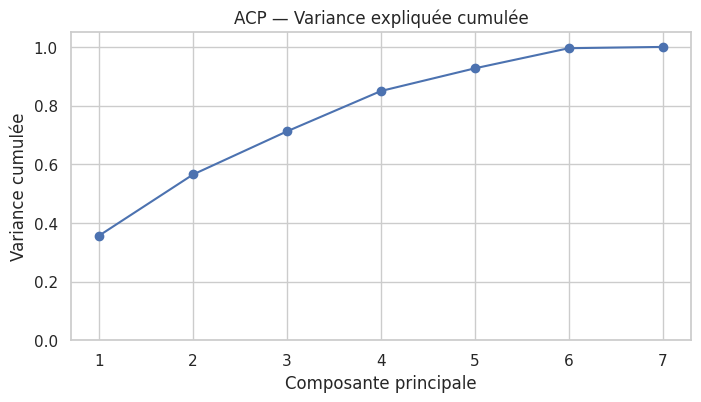

In [7]:
plt.figure(figsize=(8,4))
plt.plot(range(1, len(explained)+1), explained, marker="o")
plt.title("ACP — Variance expliquée par composante (Scree plot)")
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(range(1, len(cum_explained)+1), cum_explained, marker="o")
plt.title("ACP — Variance expliquée cumulée")
plt.xlabel("Composante principale")
plt.ylabel("Variance cumulée")
plt.ylim(0, 1.05)
plt.show()


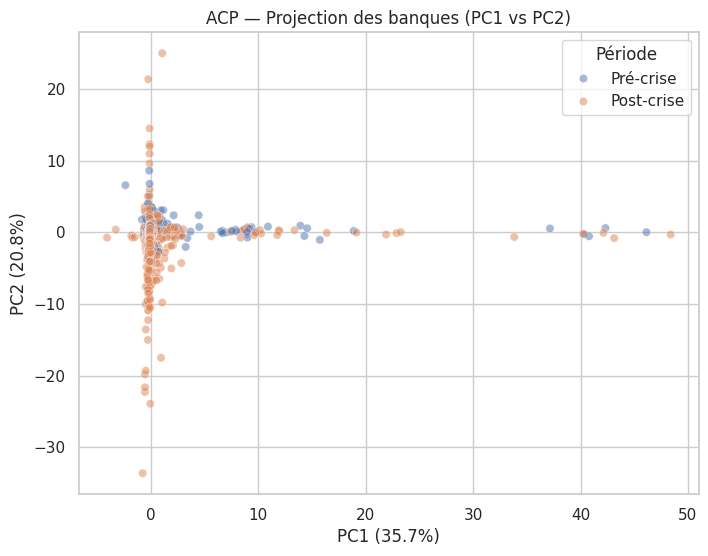

In [8]:
pca_2 = PCA(n_components=2)
scores_2 = pca_2.fit_transform(X_scaled)

scores_df = pd.DataFrame(scores_2, columns=["PC1", "PC2"])
scores_df["periode"] = df["periode"].values
scores_df["country_code"] = df["country_code"].values
scores_df["institution_name"] = df["institution_name"].values

pc1 = pca_2.explained_variance_ratio_[0]*100
pc2 = pca_2.explained_variance_ratio_[1]*100

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=scores_df, x="PC1", y="PC2",
    hue="periode", alpha=0.5
)
plt.title("ACP — Projection des banques (PC1 vs PC2)")
plt.xlabel(f"PC1 ({pc1:.1f}%)")
plt.ylabel(f"PC2 ({pc2:.1f}%)")
plt.legend(title="Période")
plt.show()


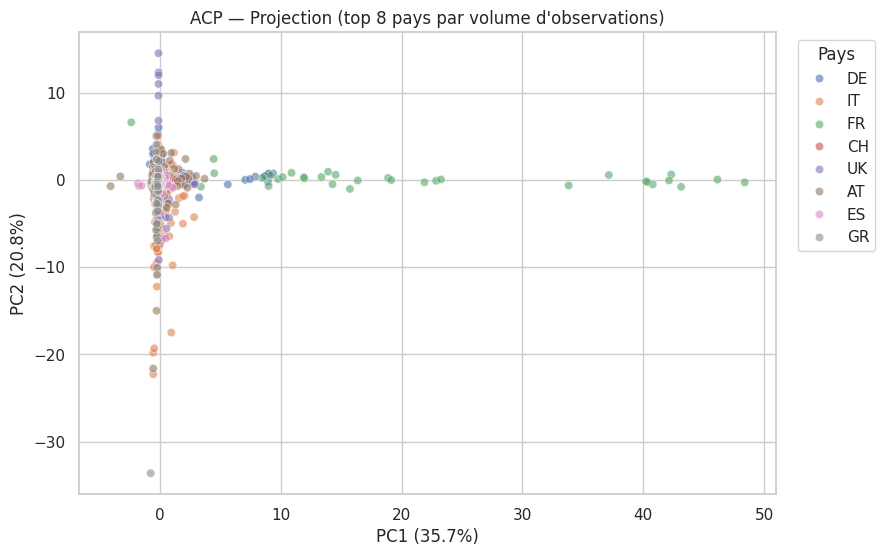

In [9]:
top_countries = df["country_code"].value_counts().head(8).index
tmp = scores_df[scores_df["country_code"].isin(top_countries)].copy()

plt.figure(figsize=(9,6))
sns.scatterplot(data=tmp, x="PC1", y="PC2", hue="country_code", alpha=0.6)
plt.title("ACP — Projection (top 8 pays par volume d'observations)")
plt.xlabel(f"PC1 ({pc1:.1f}%)")
plt.ylabel(f"PC2 ({pc2:.1f}%)")
plt.legend(title="Pays", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()


In [10]:
loadings = pd.DataFrame(
    pca_2.components_.T,
    index=vars_pca,
    columns=["PC1_loading", "PC2_loading"]
)
loadings


,PC1_loading,PC2_loading
ass_total,0.603732,-0.007911
ass_trade,0.608966,-0.005875
inc_trade,0.503677,0.000072
in_roa,-0.005302,0.704106
rt_rwa,-0.099093,-0.012409
in_roe,0.018968,0.704018
in_trade,0.027732,-0.091335


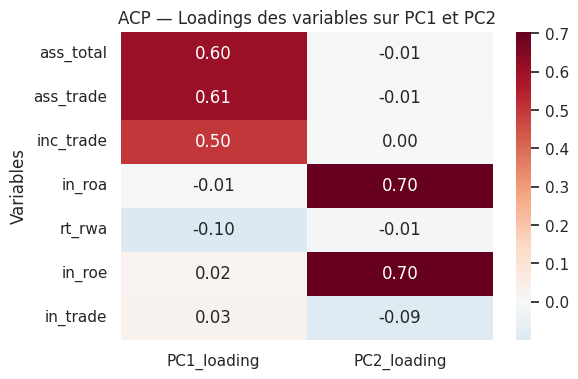

In [11]:
plt.figure(figsize=(6,4))
sns.heatmap(loadings, annot=True, fmt=".2f", center=0, cmap="RdBu_r")
plt.title("ACP — Loadings des variables sur PC1 et PC2")
plt.ylabel("Variables")
plt.show()


In [ ]:
# ACP (PCA) — Graphique PC1 vs PC2 pour les 8 pays les plus représentés
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set_theme(style="whitegrid")

# ----------------------------
# 1) Charger les données
# ----------------------------
df = pd.read_csv("Theme4_coop_zoom_data.xlsx - coop_zoom_data.csv")

# Supprime colonne parasite si elle existe
df = df.drop(columns=["Unnamed: 10"], errors="ignore")

# Colonnes numériques utilisées pour l'ACP
num_cols = ["ass_total", "ass_trade", "inc_trade", "in_roa", "rt_rwa", "in_roe", "in_trade"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", "."), errors="coerce")

# Période (si tu veux l'afficher plus tard)
df["periode"] = np.where(df["year"] <= 2010, "Pré-crise", "Post-crise")

# ----------------------------
# 2) Sélectionner les 8 pays les plus représentés
# ----------------------------
top8 = df["country_code"].value_counts().head(8).index
df_top = df[df["country_code"].isin(top8)].copy()

# ----------------------------
# 3) Préparer X (imputation médiane + standardisation)
# ----------------------------
vars_pca = [c for c in num_cols if c in df_top.columns]
X = df_top[vars_pca].copy()

# Imputation médiane (évite de perdre des lignes)
for v in vars_pca:
    X[v] = X[v].fillna(X[v].median())

X_scaled = StandardScaler().fit_transform(X)

# ----------------------------
# 4) ACP et coordonnées PC1/PC2
# ----------------------------
pca = PCA(n_components=2)
scores = pca.fit_transform(X_scaled)

scores_df = pd.DataFrame(scores, columns=["PC1", "PC2"])
scores_df["country_code"] = df_top["country_code"].values

pc1 = pca.explained_variance_ratio_[0] * 100
pc2 = pca.explained_variance_ratio_[1] * 100

# ----------------------------
# 5) Plot PC1 vs PC2 par pays (top 8)
# ----------------------------
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=scores_df,
    x="PC1", y="PC2",
    hue="country_code",
    alpha=0.6
)

plt.title("ACP (PCA) — Projection PC1 vs PC2 (Top 8 pays)")
plt.xlabel(f"PC1 ({pc1:.1f}%)")
plt.ylabel(f"PC2 ({pc2:.1f}%)")
plt.legend(title="Pays", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [12]:
abs_pc1 = loadings["PC1_loading"].abs().sort_values(ascending=False)
abs_pc2 = loadings["PC2_loading"].abs().sort_values(ascending=False)

print("Variables les plus importantes sur PC1 :")
display(abs_pc1.head(5))

print("Variables les plus importantes sur PC2 :")
display(abs_pc2.head(5))


Variables les plus importantes sur PC1 :


ass_trade    0.608966
ass_total    0.603732
inc_trade    0.503677
rt_rwa       0.099093
in_trade     0.027732
Name: PC1_loading, dtype: float64

Variables les plus importantes sur PC2 :


in_roa       0.704106
in_roe       0.704018
in_trade     0.091335
rt_rwa       0.012409
ass_total    0.007911
Name: PC2_loading, dtype: float64

## Interprétation (à compléter)

- **PC1** semble représenter : (ex: taille / intensité du bilan…)
  - variables dominantes : …

- **PC2** semble représenter : (ex: rentabilité / risque…)
  - variables dominantes : …

### Lecture pré vs post-crise
- Si les points post-crise se déplacent surtout sur PC1 : cela suggère …
- Si la dispersion augmente : divergence des business models
